In [79]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from cp_hw6 import pixel2ray
from mpl_toolkits.mplot3d import Axes3D

Stick shadow is casted on the frog only in the images from 57 to 160

(104, 768, 1024)
(768, 1024)


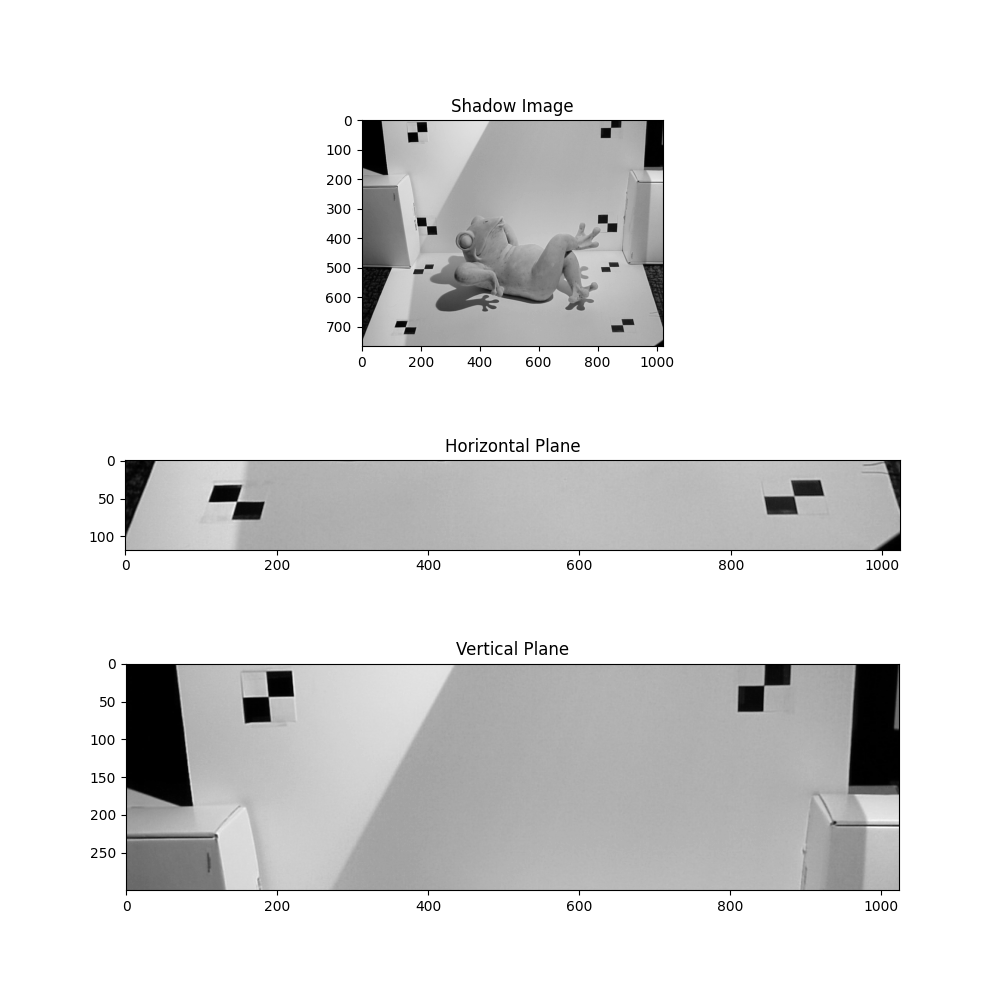

In [69]:
images_path = "../data/frog"
selected_images = [img for img in sorted(os.listdir(images_path)) if "000057" <= img[:6] <= "000160"]
images = [cv2.cvtColor(cv2.imread(os.path.join(images_path, image)), cv2.COLOR_BGR2GRAY) for image in selected_images]
images = np.array(images)
print(images.shape)
Imax = np.max(images, axis=0)
Imin = np.min(images, axis=0)
Ishadow = ((Imax.astype(np.float32) + Imin.astype(np.float32)) / 2).astype(np.uint8)
print(Ishadow.shape)
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
plt.title("Shadow Image")
plt.imshow(Ishadow, cmap="gray")
plt.subplot(3,1,2)
plt.title("Horizontal Plane")
plt.imshow(Ishadow[650:,:], cmap="gray")
plt.subplot(3,1,3)
plt.title("Vertical Plane")
plt.imshow(Ishadow[:300,:], cmap="gray")
plt.show()

image_color = cv2.imread("../data/frog/000001.jpg")
image_color = cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB)

Per Frame Shadow Edge Estimation

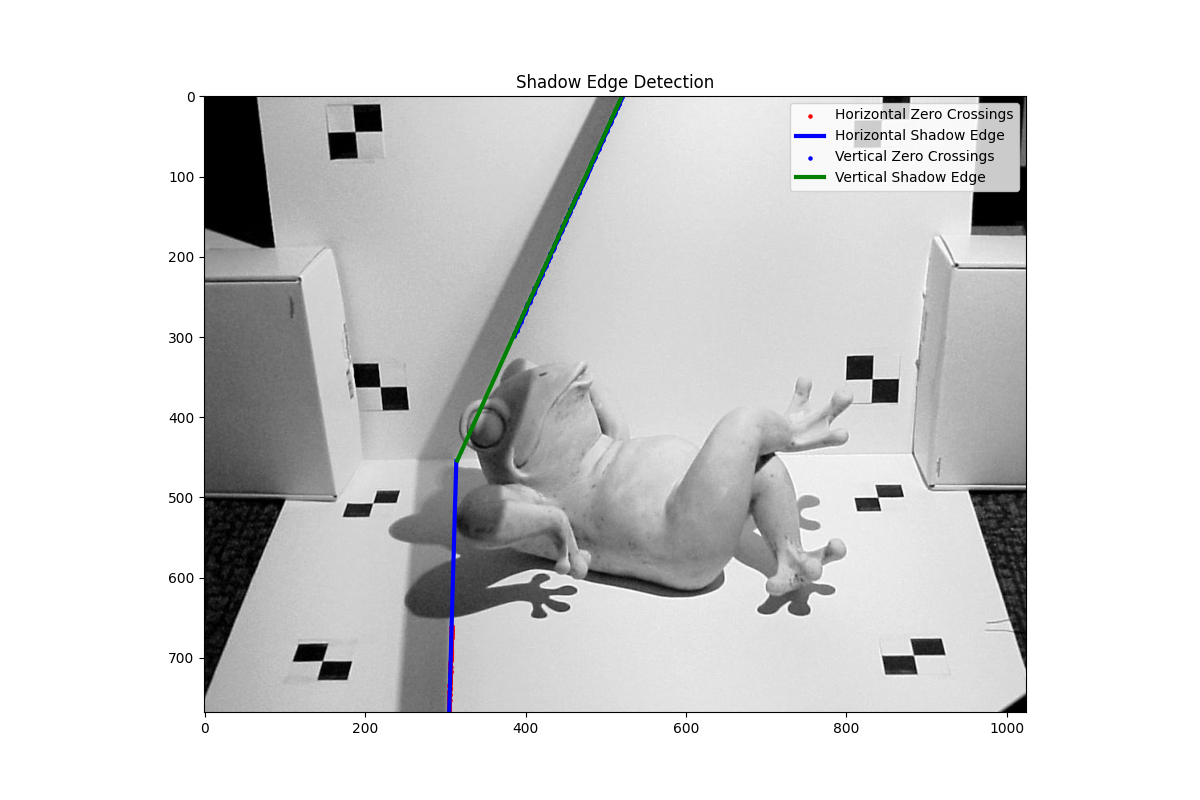

In [112]:
def estimate_shadow_edges(images, Ishadow, horizontal_rows, vertical_rows, column_offsets):
    lambda_h_t = []
    lambda_v_t = []
    zero_crossings_h_per_frame = []
    zero_crossings_v_per_frame = []
    
    for t in range(images.shape[0]):
        delta_I = images[t].astype(float) - Ishadow.astype(float)
        # plt.imshow(delta_I, cmap="gray")
        zero_crossings_h = []
        for y in horizontal_rows:
            delta_rows = delta_I[y,:]
            for x in column_offsets:
                if (delta_rows[x - 1] < 0 and delta_rows[x] >= 0) and (Imax[y,x] - Imin[y,x] > 50) and (Imax[y,x-1] - Imin[y,x-1] > 50):
                    zero_crossings_h.append((x, y))
                    break
                    
        zero_crossings_v = []
        for y in vertical_rows:
            delta_rows = delta_I[y,:]
            for x in column_offsets:
                if (delta_rows[x - 1] < 0 and delta_rows[x] >= 0) and (Imax[y,x] - Imin[y,x] > 50) and (Imax[y,x-1] - Imin[y,x-1] > 50):
                    zero_crossings_v.append((x, y))
                    break
        
        if len(zero_crossings_h) > 0:
            zero_crossings_h = np.array(zero_crossings_h)
            A_h = np.hstack((zero_crossings_h, np.ones((zero_crossings_h.shape[0], 1))))
            _, _, Vt_h = np.linalg.svd(A_h)
            lambda_h_t.append(Vt_h[-1])
            zero_crossings_h_per_frame.append(zero_crossings_h)
            
        if len(zero_crossings_v) > 0:
            zero_crossings_v = np.array(zero_crossings_v)
            A_v = np.hstack((zero_crossings_v, np.ones((zero_crossings_v.shape[0], 1))))
            _, _, Vt_v = np.linalg.svd(A_v)
            lambda_v_t.append(Vt_v[-1])
            zero_crossings_v_per_frame.append(zero_crossings_v)
            
    return lambda_h_t, lambda_v_t, zero_crossings_h_per_frame, zero_crossings_v_per_frame

def visualize_shadow_edges(image, lambda_h, lambda_v, zero_crossings_h, zero_crossings_v, 
                         horizontal_rows, vertical_rows):
    plt.figure(figsize=(12, 8))
    plt.imshow(image, cmap='gray')
    
    if zero_crossings_h.size > 0:
        plt.scatter(zero_crossings_h[:, 0], zero_crossings_h[:, 1], 
                   c='r', s=5, label='Horizontal Zero Crossings')
        
        if lambda_h is not None:
            a, b, c = lambda_h
            if abs(b) > 1e-6:
                y_coords = np.array([i for i in range(horizontal_rows[0], horizontal_rows[1])])
                x_coords = -(b * y_coords + c) / a
                plt.plot(x_coords, y_coords, 'b-', linewidth=3, 
                        label='Horizontal Shadow Edge')
            else:  
                x_fixed = -c / a
                plt.axvline(x=x_fixed, color='b', label='Horizontal Shadow Edge')
    
    if zero_crossings_v.size > 0:
        plt.scatter(zero_crossings_v[:, 0], zero_crossings_v[:, 1], 
                   c='b', s=5, label='Vertical Zero Crossings')
        
        if lambda_v is not None:
            a, b, c = lambda_v
            if abs(b) > 1e-6:
                y_coords = np.array([i for i in range(vertical_rows[0], vertical_rows[1])])
                x_coords = -(b * y_coords + c) / a
                plt.plot(x_coords, y_coords, 'g-', linewidth=3, 
                        label='Vertical Shadow Edge')
            else:  
                x_fixed = -c / a
                plt.axvline(x=x_fixed, color='b', label='Horizontal Shadow Edge')

    plt.title('Shadow Edge Detection')
    plt.legend()
    plt.show()

unobstructed_horizontal_rows = range(660, 768)
unobstructed_vertical_rows = range(0, 300)
column_offsets = range(200, 900)

lambda_h_t, lambda_v_t, zero_crossings_h, zero_crossings_v = estimate_shadow_edges(
    images, Ishadow, 
    unobstructed_horizontal_rows, 
    unobstructed_vertical_rows, 
    column_offsets
)

frame_idx = 45
visualize_shadow_edges(
    images[frame_idx],
    lambda_h_t[frame_idx],
    lambda_v_t[frame_idx],
    zero_crossings_h[frame_idx],
    zero_crossings_v[frame_idx],
    horizontal_rows=(455, 768),
    vertical_rows=(0, 455)
)

Per-pixel shadow time estimation

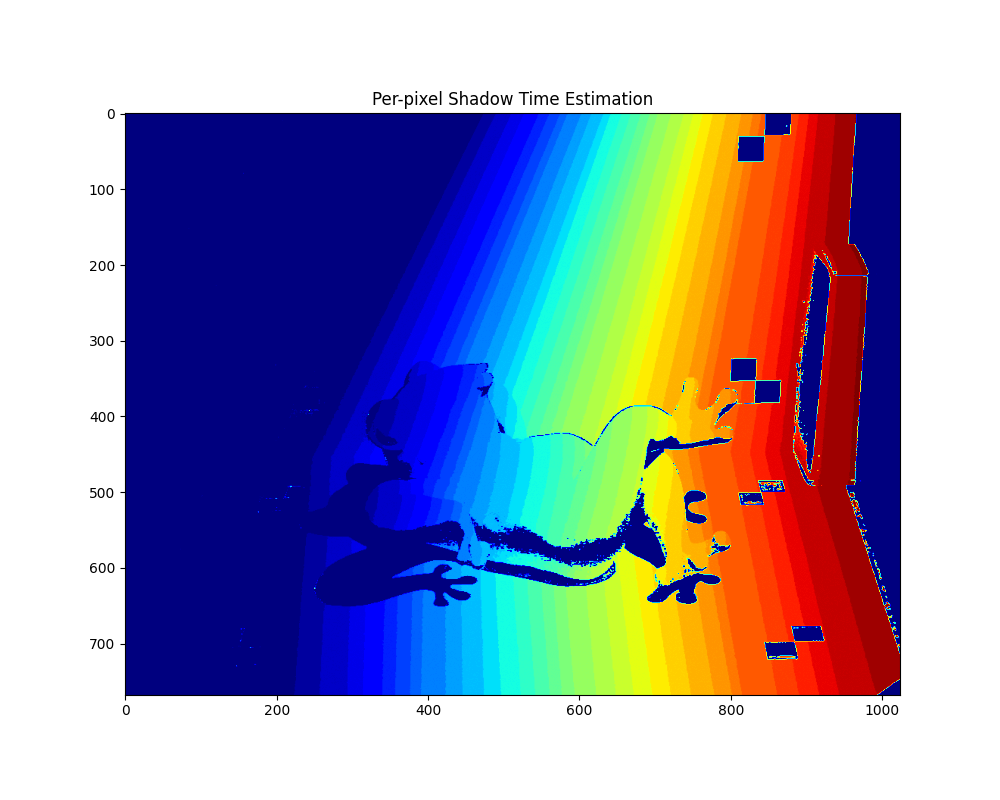

In [100]:
def estimate_shadow_times(images, Ishadow):
    shadow_times = np.zeros(images[0].shape)
    for y in range(images[0].shape[0]):
        for x in range(images[0].shape[1]):
            for t in range(1, len(images)):
                delta_prev = images[t-1][y,x].astype(float) - Ishadow[y,x].astype(float)
                delta_curr = images[t][y,x].astype(float) - Ishadow[y,x].astype(float)
                if (delta_prev >= 0 and delta_curr < 0) and (Imax[y,x] - Imin[y,x] > 50) and (Imax[y,x-1] - Imin[y,x-1] > 50):
                    shadow_times[y,x] = t
                    break

    max_time = len(images)
    shadow_times = np.round(shadow_times * 32 / max_time)
    return shadow_times

def visualize_shadow_times(shadow_times):
    plt.figure(figsize=(10, 8))
    plt.imshow(shadow_times, cmap='jet')
    plt.title('Per-pixel Shadow Time Estimation')
    plt.show()

shadow_times = estimate_shadow_times(images, Ishadow)
visualize_shadow_times(shadow_times)

Intrinsic and Extrinsic Calibration

In [101]:
intrinsic_mtx = np.load("../data/calib/intrinsic_calib.npz")
extrinsic_mtx = np.load("../data/frog/extrinsic_calib.npz")
K, D = intrinsic_mtx["mtx"], intrinsic_mtx["dist"]
R_h, T_h = extrinsic_mtx["rmat_h"], extrinsic_mtx["tvec_h"]
R_v, T_v = extrinsic_mtx["rmat_v"], extrinsic_mtx["tvec_v"]
print(f"Intrinsic matrix: \n {K}")
print(f"Distortion Coeffs: \n {D}")
print(f"Rotation matrix of Horizontal plane: \n {R_h}")
print(f"Translation matrix of Horizontal plane: \n {T_h}")
print(f"Rotation matrix of Vertical plane: \n {R_v}")
print(f"Translation matrix of Vertical plane: \n {T_v}")

Intrinsic matrix: 
 [[2.06259072e+03 0.00000000e+00 5.68921852e+02]
 [0.00000000e+00 2.06726817e+03 4.30545709e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Coeffs: 
 [[-1.64147015e-01  1.64429797e-01  6.58747314e-03  4.01261502e-03
   1.16492475e+01]]
Rotation matrix of Horizontal plane: 
 [[ 0.9998436   0.00558949 -0.01677909]
 [-0.01235164 -0.45832851 -0.88869703]
 [-0.0126577   0.88876528 -0.45818779]]
Translation matrix of Horizontal plane: 
 [[-321.20921701]
 [ 207.28284011]
 [1560.14966184]]
Rotation matrix of Vertical plane: 
 [[ 0.99951543 -0.02580163 -0.01741216]
 [-0.01427909 -0.87711828  0.48006212]
 [-0.02765891 -0.47958087 -0.87706167]]
Translation matrix of Vertical plane: 
 [[-320.35740354]
 [ -62.44542456]
 [1877.40479951]]


Conversion between coordinates systems of camera and the planes

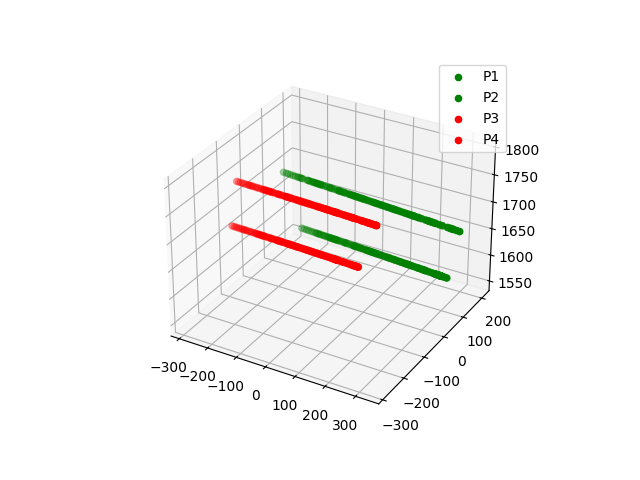

In [102]:
frame_num = 30

def cam_to_plane(point, R, T):
    point_plane = R.T @ (point - T)
    return point_plane

def plane_to_cam(point, R, T):
    point_cam = R @ point + T
    return point_cam

def get_horizontal_plane_points(lambda_h):
    y1, y2 = 600, 700
    a, b, c = lambda_h
    x1 = int(-(b * y1 + c) / a)
    x2 = int(-(b * y2 + c) / a)
    return [(x1, y1), (x2, y2)]

def get_vertical_plane_points(lambda_v):
    y1, y2 = 100, 200
    a, b, c = lambda_v
    x1 = int(-(b * y1 + c) / a)
    x2 = int(-(b * y2 + c) / a)
    return [(x1, y1), (x2, y2)]

def intersect_ray_with_plane(ray_cam, R_p, T_p):
    d_p = R_p.T @ ray_cam
    C_c = np.zeros((3, 1))
    C_p = R_p.T @ (C_c - T_p)
    s = -C_p[2] / d_p[2]
    X_p = C_p + s * d_p
    intersection_point_cam = R_p @ X_p + T_p
    return intersection_point_cam.flatten()

P1_list = []
P2_list = []
P3_list = []
P4_list = []
frame_indices = []

num_frames = len(lambda_h_t)

for frame_num in range(num_frames):
    lambda_h = lambda_h_t[frame_num]
    lambda_v = lambda_v_t[frame_num]
    p1, p2 = get_horizontal_plane_points(lambda_h)
    r1 = np.reshape(pixel2ray(p1, K, D), (3, 1))
    r2 = np.reshape(pixel2ray(p2, K, D), (3, 1))
    P1 = intersect_ray_with_plane(r1, R_h, T_h)
    P2 = intersect_ray_with_plane(r2, R_h, T_h)
    p3, p4 = get_vertical_plane_points(lambda_v)
    r3 = np.reshape(pixel2ray(p3, K, D), (3, 1))
    r4 = np.reshape(pixel2ray(p4, K, D), (3, 1))
    P3 = intersect_ray_with_plane(r3, R_v, T_v)
    P4 = intersect_ray_with_plane(r4, R_v, T_v)
    if P1 is not None and P2 is not None and P3 is not None and P4 is not None:
        P1_list.append(P1)
        P2_list.append(P2)
        P3_list.append(P3)
        P4_list.append(P4)
        frame_indices.append(frame_num)

P1_array = np.array(P1_list)
P2_array = np.array(P2_list)
P3_array = np.array(P3_list)
P4_array = np.array(P4_list)
frame_indices = np.array(frame_indices)

np.savez('shadow_lines_3D_points.npz',
         P1=P1_array,
         P2=P2_array,
         P3=P3_array,
         P4=P4_array,
         frames=frame_indices)

%matplotlib ipympl
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(P1_array[:,0],P1_array[:,1],P1_array[:,2], c='g', label='P1')
ax.scatter(P2_array[:,0],P2_array[:,1],P2_array[:,2], c='g', label='P2')
ax.scatter(P3_array[:,0],P3_array[:,1],P3_array[:,2], c='r', label='P3')
ax.scatter(P4_array[:,0],P4_array[:,1],P4_array[:,2], c='r', label='P4')
plt.legend()

In [103]:

def get_shadow_planes(P1_array, P2_array, P3_array, P4_array, frame_indices):
    normals= []
    for frame_num in frame_indices:
        v1 = P2_array[frame_num] - P1_array[frame_num]
        v2 = P4_array[frame_num] - P3_array[frame_num]
        normal = np.cross(v1, v2)
        n_hat = normal / np.linalg.norm(normal)
        normals.append(n_hat)
    return np.array(normals)
        
n_hat_array = get_shadow_planes(P1_array, P2_array, P3_array, P4_array, frame_indices)
np.savez("shadow_planes_params.npz", n_hat = n_hat_array, P1 = P1_array, frames = frame_indices)

Reconstruction

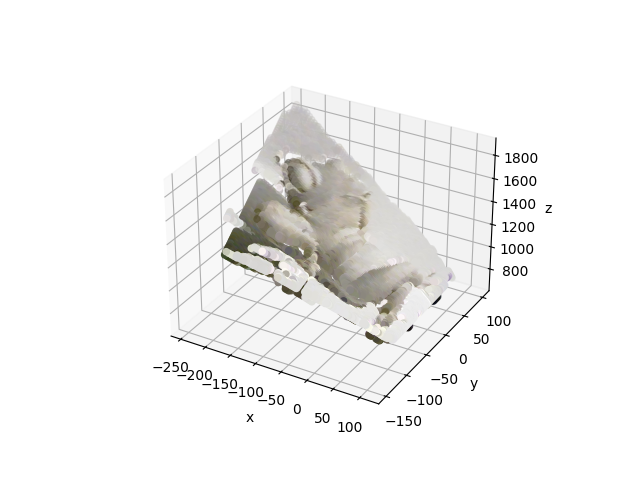

In [111]:
def reconstruct_3d_shape(P1_array, n_hat_array, shadow_times, x_range, y_range, frame_indices, R_h, R_v, T_h, T_v, step_size=4):
    points_3d = []
    colors = []
    frame_to_index = {frame: idx for idx, frame in enumerate(frame_indices)}
    
    for y in range(y_range[0], y_range[1], step_size):  
        for x in range(x_range[0], x_range[1], step_size):
            t = int(shadow_times[y, x])
            idx = frame_to_index[t]
            P1 = P1_array[idx].flatten()  
            n_hat = n_hat_array[idx].flatten()  
            ray_cam = pixel2ray((x, y), K, D).flatten()   
            Cc = np.zeros(3)  
            numerator = np.dot(P1 - Cc, n_hat)  
            denominator = np.dot(ray_cam, n_hat)  
            if abs(denominator) < 1e-6:
                continue  
            s = numerator / denominator
            if s < 0:
                continue
            P = Cc + s * ray_cam  

            points_3d.append(P)
            color = image_color[y, x]
            colors.append(color)
    points_3d = np.array(points_3d)
    colors = np.array(colors)
    return points_3d, colors

y_range = (320, 650)  
x_range = (300, 820)

points_3d, colors = reconstruct_3d_shape(
     P1_array, n_hat_array, shadow_times, x_range, y_range, frame_indices, R_h, R_v, T_h, T_v, step_size=4
)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(points_3d[:,0],-points_3d[:,1],points_3d[:,2],c=colors/255)

min_depth = -10
max_depth = 10

depth_mask = (points_3d[:, 2] >= min_depth) & (points_3d[:, 2] <= max_depth)

filtered_points = points_3d[depth_mask]
filtered_colors = colors[depth_mask]

ax.scatter(filtered_points[:, 0], -filtered_points[:, 1], filtered_points[:, 2], c=filtered_colors/255)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()